## SCALib Test

Module AES128 not found, compiling instrumented Tiny-AES shared library


AES128.c:988:13: warning: ‘Cipher’ defined but not used [-Wunused-function]
  988 | static void Cipher(state_t* state, const uint8_t* RoundKey)
      |             ^~~~~~


Module AES192 not found, compiling instrumented Tiny-AES shared library


AES192.c:624:9: warning: ‘AES_KEYLEN’ redefined
  624 | #define AES_KEYLEN 16   // Key length in bytes
      |         ^~~~~~~~~~
<command-line>: note: this is the location of the previous definition
AES192.c:988:13: warning: ‘Cipher’ defined but not used [-Wunused-function]
  988 | static void Cipher(state_t* state, const uint8_t* RoundKey)
      |             ^~~~~~


Module AES256 not found, compiling instrumented Tiny-AES shared library


AES256.c:624:9: warning: ‘AES_KEYLEN’ redefined
  624 | #define AES_KEYLEN 16   // Key length in bytes
      |         ^~~~~~~~~~
<command-line>: note: this is the location of the previous definition
AES256.c:988:13: warning: ‘Cipher’ defined but not used [-Wunused-function]
  988 | static void Cipher(state_t* state, const uint8_t* RoundKey)
      |             ^~~~~~


Ignoring exception:
('No input specification for OracleAES: input_conditions must be declared in OracleAES.__new__', "'OracleAES' object has no attribute 'input_conditions'")
Ignoring exception:
('No input specification for OracleAES: input_conditions must be declared in OracleAES.__new__', "'OracleAES' object has no attribute 'input_conditions'")
Ignoring exception:
('No input specification for OracleAES: input_conditions must be declared in OracleAES.__new__', "'OracleAES' object has no attribute 'input_conditions'")
Ignoring exception:
('No input specification for OracleAES: input_conditions must be declared in OracleAES.__new__', "'OracleAES' object has no attribute 'input_conditions'")


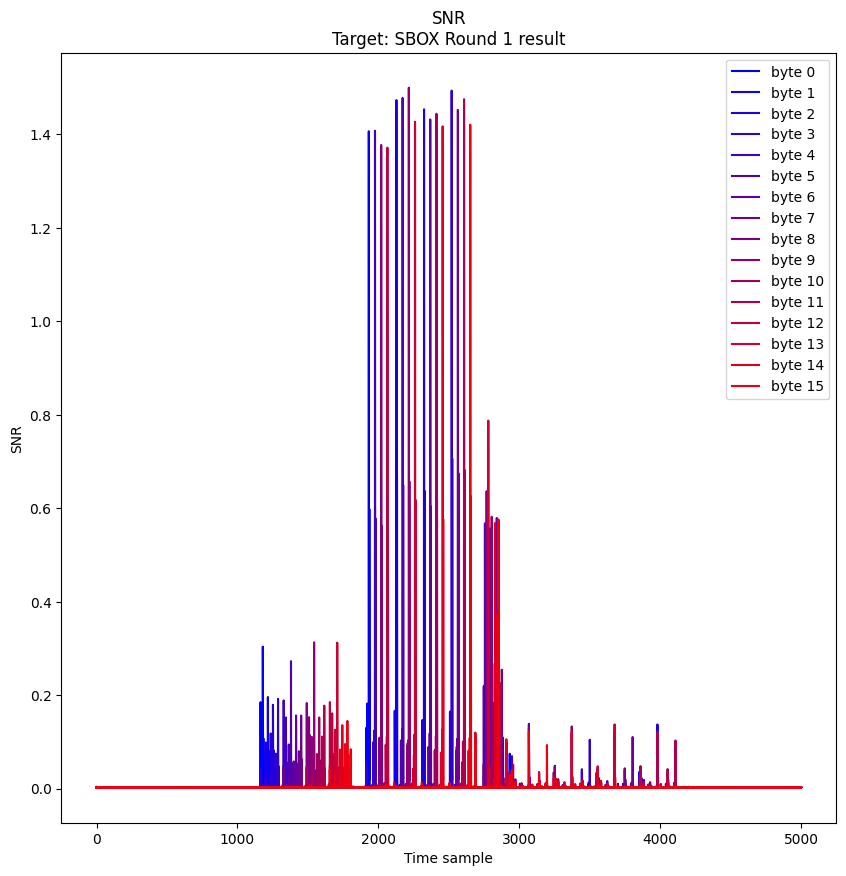

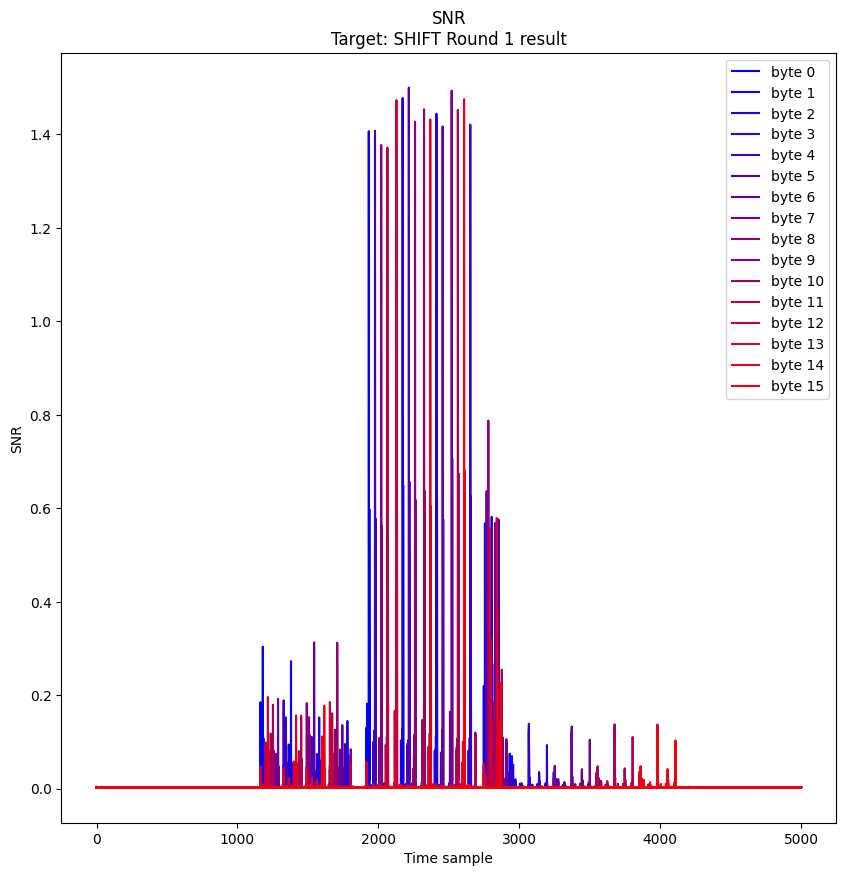

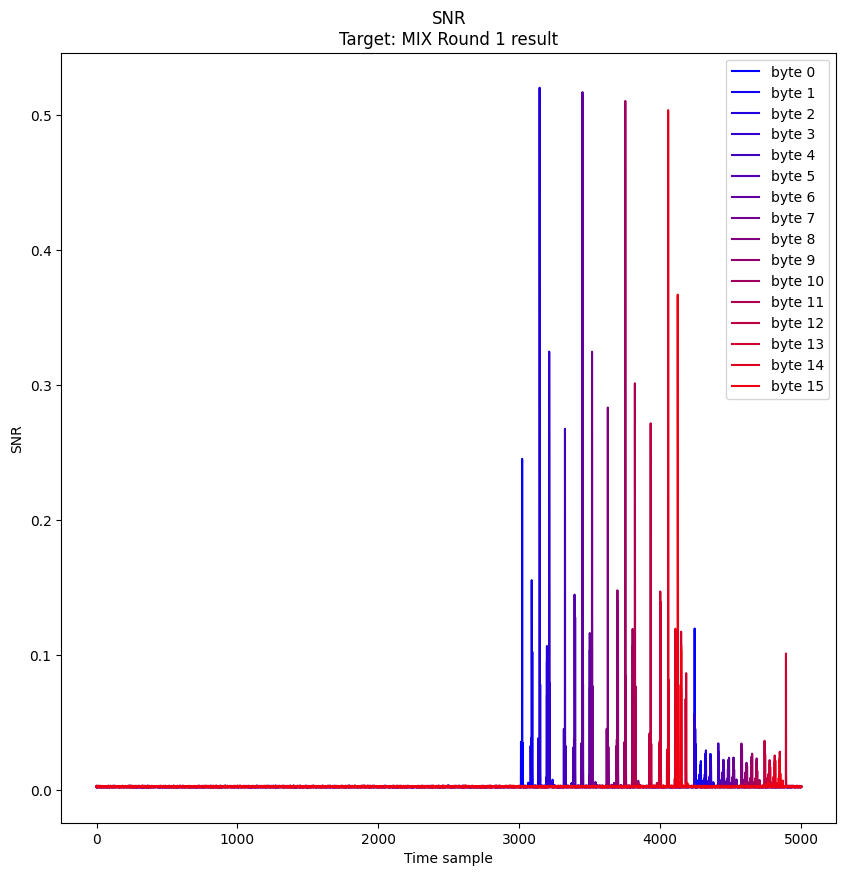

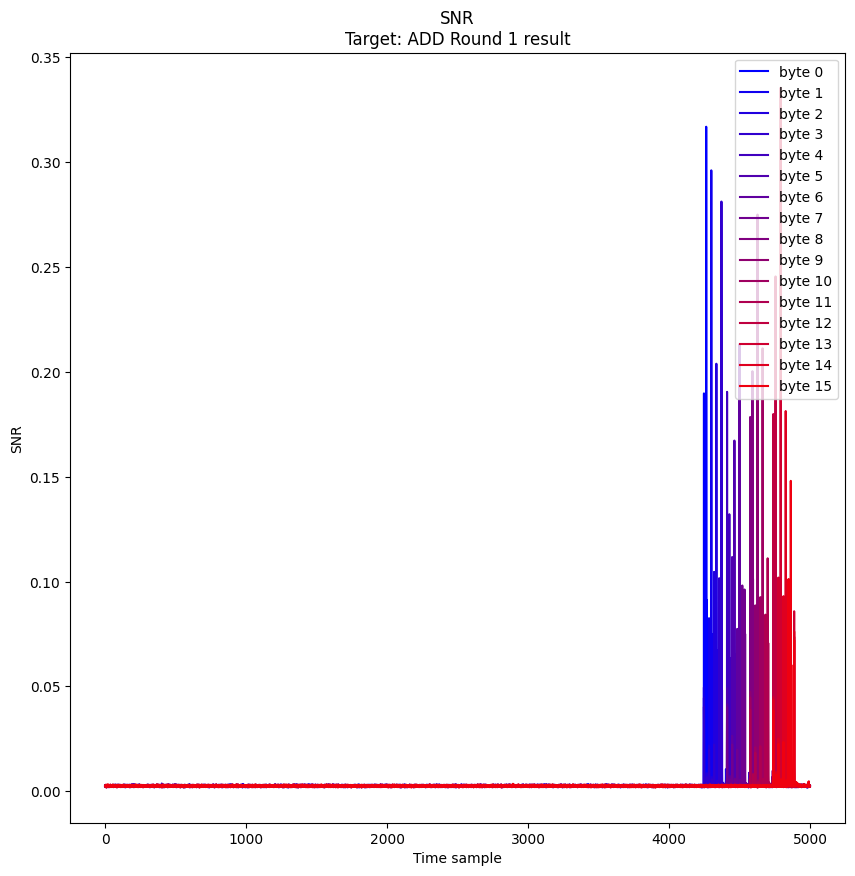

In [1]:
# from scalib.metrics import SNR
from matplotlib import pyplot as plt
from time import perf_counter_ns
import os
import numpy as np

from src.zarr_handler import DaskZarrHandler
from src.dask_operation import OracleAES, SNR, NICV

def preset_plot(data: np.ndarray, plot_size: tuple[int, int], lq_name: str, subtitle: str):
    plt.figure(figsize=plot_size)
    for i in range(data.shape[0]):
        plt.plot(np.arange(data.shape[1]), data[i, :], label=f"byte {i}", color=(i/data.shape[0], 0, 1-(i/data.shape[0])))
        plt.legend(loc='upper right')
        plt.title(f"{lq_name}\n{subtitle}")
        plt.xlabel("Time sample")
        plt.ylabel(lq_name)
    plt.savefig(f"figure-{subtitle.lower()}.png", dpi=300)
    # plt.show()

# import dataset
def local_dataset(name: str) -> str:
    return os.path.join(os.path.expanduser("~"), "Nextcloud", "UNH", "Research", "Projects", "SCA Datasets", name + '.zarr')
dataset_name = "SAM4S 100000 random Traces [50c]"
dset_handle = DaskZarrHandler(local_dataset(dataset_name), chunksize=2000)

# get data
k = dset_handle.get_dask_array(0, 0, "key")
ct = dset_handle.get_dask_array(0, 0, "ciphertext")
t = dset_handle.get_dask_array(0, 0, "traces")

# instantiate oracle
for target in ((1, 'sbox'), (1, 'shift'), (1, 'mix'), (1, 'add')):
    oracle = OracleAES(
        aes_type=128, keys=k, texts=ct, 
        round=target[0], step=target[1],    # finds intermediate state at round 'round' step 'step'
        lazy=False                          # lazy=False computes results immedietly on init
    )

    # instantiate SNR
    snr = SNR(t, oracle.result)

    # plot results
    preset_plot(snr.snr, (10, 10), "SNR", f"Target: {target[1].upper()} Round {target[0]} result")




## Figures / data for OPTIMIST Presentation

In [ ]:
from src.ral_scarr.engines.NICV import NICV
from src.ral_scarr.engines.snr import SNR
from src.ral_scarr.file_handling.trace_handler import TraceHandler as th
from src.ral_scarr.container.container import Container, ContainerOptions
from src.ral_scarr.model_values.ciphertext import CipherText

def preset_plot(data: np.ndarray, plot_size: tuple[int, int], lq_name: str, subtitle: str):
    plt.figure(figsize=plot_size)
    for i in range(results.shape[0]):
        plt.plot(np.arange(results.shape[1]), results[i, :], label=f"byte {i}", color=(i/results.shape[0], 0, 1-(i/results.shape[0])))
        plt.legend(loc='upper right')
        plt.title(f"{lq_name}\n{subtitle}")
        plt.xlabel("Time sample")
        plt.ylabel(lq_name)
        plt.show()

dataset_name = "SAM4S 100000 random Traces [50c]"
handler = th(fileName=local_dataset(dataset_name), batchSize=5000)
engine = SNR()
container = Container(options=ContainerOptions(engine=engine, handler=handler), model_positions=[i for i in range(16)])
container.run()
results = np.squeeze(engine.get_result())
preset_plot(results, (10, 10), "SNR", "")



ModuleNotFoundError: No module named 'src.ral_scarr'